In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os

# Load video and extract frames
def extract_frames(video_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(f'{output_dir}/{frame_count:05d}.jpg', frame)
        frame_count += 1

    cap.release()
    print(f'{frame_count} frames extracted to {output_dir}')

# Example usage
extract_frames('/content/drive/MyDrive/VID20240813020800.mp4', 'frames/')

301 frames extracted to frames/


In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-eeucfdmu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-eeucfdmu
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 7e1596c0b6462eb1d1ba7e1492430fed95023598
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.3 MB/s eta 0:00:00
  Created w

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [ ]:

'''def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
      if obj_id == -1:
        color = np.array([1, 1, 1, 1.0])
      else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)'''
'''
def show_mask(mask, ax, image=None, obj_id=None, random_color=False,save_path=None):
    # Create a black background for the entire image (3 channels for RGB)
    if image is not None:
        black_background = np.zeros_like(image)
    else:
        h, w = mask.shape[-2:]
        black_background = np.zeros((h, w, 3))  # Handle case where no image is provided

    # Set color of the mask
    if obj_id == -1:  # Set to white for obj_id == -1
        color = np.array([1, 1, 1])  # White RGB (no alpha channel)
    else:
        if random_color:
            color = np.random.random(3)  # Use random RGB values
        else:
            cmap = plt.get_cmap("tab10")
            cmap_idx = 0 if obj_id is None else obj_id
            color = np.array([*cmap(cmap_idx)[:3]])  # Adjust as needed (no alpha channel)

    # Extract dimensions
    h, w = mask.shape[-2:]

    # Create the white mask for the object (no alpha channel)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    # Background stays black outside the mask
    masked_background = black_background * (1 - mask.reshape(h, w, 1))  # Keeps background black

    # Display the black background with the white mask (combine)
    final_image=masked_background + mask_image
    ax.imshow(final_image)
    if save_path is not None:
        # Convert to a PIL Image and save
        Image.fromarray(final_image).save(save_path)
'''
def show_mask(mask, ax, obj_id=None, save_path=None):
    # Ensure the mask is in the correct shape
    h, w = mask.shape[-2:]

    # Create a black background (3 channels for RGB)
    black_background = np.zeros((h, w, 3), dtype=np.uint8)  # Black RGB

    # Set color for the mask (white RGB)
    color = np.array([255, 255, 255], dtype=np.uint8)  # White for the mask

    # Reshape the mask to apply it on each channel
    mask_3channel = mask.reshape(h, w, 1)  # Make sure mask has shape (h, w, 1)

    # Create the white mask for the object
    mask_image = mask_3channel * color  # Apply white color to the mask

    # Combine the mask with the black background
    final_image = black_background + mask_image

    # Display the final image with the mask
    ax.imshow(final_image)

    # Save the mask image if a path is provided
    if save_path is not None:
        Image.fromarray(final_image).save(save_path)

    # Debugging prints to check mask values
    print(f"Mask shape: {mask.shape}, Max value in mask: {mask.max()}, Min value: {mask.min()}")





def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

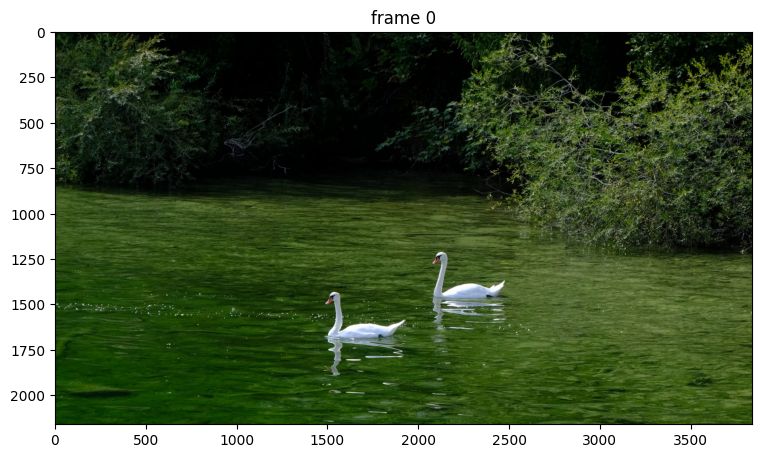

In [ ]:
video_dir = "/content/frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [ ]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 243/243 [00:46<00:00,  5.22it/s]


In [ ]:
predictor.reset_state(inference_state)

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[1750, 1650]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
c_frame=Image.open(os.path.join(video_dir, frame_names[ann_frame_idx]))
#show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=-1)


Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False


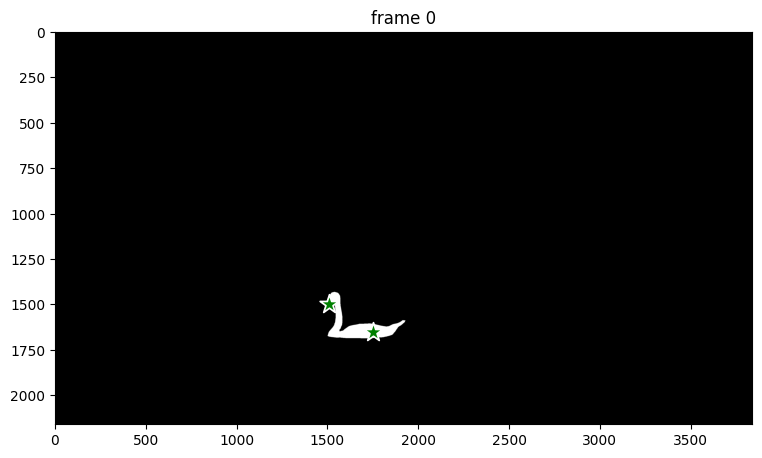

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[1750, 1650], [1510, 1500]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
c_frame=Image.open(os.path.join(video_dir, frame_names[ann_frame_idx]))
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(c_frame)
show_points(points, labels, plt.gca())
#show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=-1)

### CODE FOR DELETING FOLDER CONTENT

In [ ]:
'''import os
import shutil

folder_path = '/content/masks'

# Option 1: Delete all files, but keep the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Delete the file
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Delete a directory
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

# Option 2: Delete the entire folder (use with caution)
# shutil.rmtree(folder_path)
# os.makedirs(folder_path)  # Recreate an empty folder
'''

In [ ]:
mask_dir = '/content/masks'
os.makedirs(mask_dir, exist_ok=True)

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
      save_path = os.path.join(mask_dir, f"mask_frame_{out_frame_idx}_obj_{out_obj_id}.png")
      show_mask(out_mask, plt.gca(), obj_id=-1, save_path=save_path)



propagate in video: 100%|██████████| 243/243 [04:43<00:00,  1.17s/it]


Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask s

<ipython-input-24-7f20d58db3e9>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask shape: (1, 2160, 3840), Max value in mask: True, Min value: False
Mask s

## segment using bounding box

In [ ]:
#predictor.reset_state(inference_state)

In [ ]:
'''ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([300, 0, 500, 400], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])'''

In [ ]:
import os
from PIL import Image

# Ensure 'masks' folder exists in the parent directory of 'frames'
parent_dir = os.path.dirname(video_dir)  # Get the parent directory of 'frames'
mask_dir = os.path.join(parent_dir, 'masks')  # Create 'masks' directory in the parent directory
os.makedirs(mask_dir, exist_ok=True)

# After obtaining `out_mask_logits` for the current frame
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# Process and visualize the frame
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")

    # Load the original frame and create a black background
    original_frame = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    plt.imshow(np.zeros_like(original_frame))  # Show a black background

    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # Ensure the mask is 2D
        if out_mask.ndim > 2:
            out_mask = np.squeeze(out_mask)

        # Create a white mask where the object is present
        white_mask = np.full(out_mask.shape, 255, dtype=np.uint8)  # White where object is masked

        # Visualize the mask on black background
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

        # Save the white mask as an image
        mask_image = Image.fromarray(white_mask * out_mask.astype(np.uint8))
        mask_filename = f"m_{frame_names[out_frame_idx]}"
        mask_image.save(os.path.join(mask_dir, mask_filename))  # Save in the masks directory


NameError: name 'video_dir' is not defined

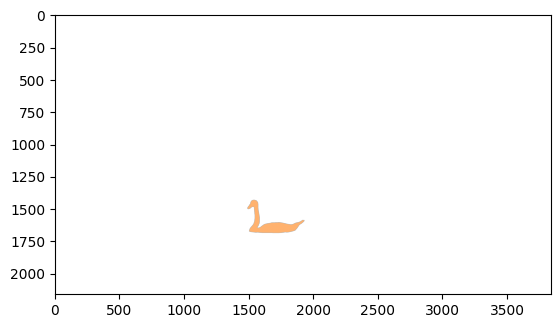

In [ ]:
show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
